In [1]:
pip install dask[complete]

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import dask.dataframe as dd
import pandas as pd
import numpy as np
import re
import time
import psutil
import tracemalloc
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def track_performance(start_time, mem_start, process, records):
    elapsed_time = time.time() - start_time
    mem_end = process.memory_info().rss / (1024 * 1024)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    throughput = records / elapsed_time if elapsed_time > 0 else 0

    print(f"\n⏱️ Elapsed Time: {elapsed_time:.2f} sec")
    print(f"📊 Memory Used (Start → End): {mem_start:.2f} MB → {mem_end:.2f} MB")
    print(f"🚀 Peak Memory (tracemalloc): {peak / 1024 / 1024:.2f} MB")
    print(f"📈 Throughput: {throughput:,.2f} records/sec")
    return elapsed_time, mem_end, peak / (1024 * 1024)


In [4]:
# 1. track performance for normal cleaning process using pandas
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# 2. Clean Data Process (Pandas)

df = pd.read_csv("Dataset.csv", encoding="ISO-8859-1")

# a. Drop duplicates
df.drop_duplicates(inplace=True)

df_copy = df.copy()

# b. Replace NaN in specific columns with "unknown"
df_copy["Product Name"].fillna("unknown", inplace=True)
df_copy["Location"].fillna("unknown", inplace=True)
df_copy["Price"].fillna("unknown", inplace=True)

# c.  Fill actual NaN with "0" in critical columns
df_copy["Quantity Sold"].fillna("0", inplace=True)
df_copy["Number of Ratings"].fillna("0", inplace=True)

# d. Clean "Quantity Sold" (e.g., "5K sold" → 5000)
import re
def clean_quantity(q):
    if isinstance(q, str):
        q = q.lower().replace("sold", "").strip()
        if "k" in q:
            return int(float(q.replace("k", "")) * 1000)
        return int(re.findall(r"\d+", q)[0]) if re.findall(r"\d+", q) else 0
    return 0

df_copy["Quantity Sold"] = df_copy["Quantity Sold"].apply(clean_quantity)

# e. Clean "Number of Ratings" (e.g., "(10)" → 10)
def clean_ratings(r):
    if isinstance(r, str):
        match = re.search(r"\d+", r)
        return int(match.group()) if match else 0
    return 0

df_copy["Number of Ratings"] = df_copy["Number of Ratings"].apply(clean_ratings)

# f. Remove non-numerical character in "Price"
df_copy["Price"] = df_copy["Price"].astype(str)

# Clean only rows that are not "unknown"
df_copy.loc[df_copy["Price"] != "unknown", "Price"] = (
    df_copy.loc[df_copy["Price"] != "unknown", "Price"]
    .str.replace(r"[^\d.]", "", regex=True)
)

# g. Convert "Price" to float and leave the word "unknown"
def to_float_or_unknown(val):
    try:
        return float(val)
    except:
        return "unknown"

df_copy["Price"] = df_copy["Price"].apply(to_float_or_unknown)


# h. Convert Quantity Sold & Number of Ratings to int
df_copy["Quantity Sold"] = df_copy["Quantity Sold"].astype(int)
df_copy["Number of Ratings"] = df_copy["Number of Ratings"].astype(int)


# Print sample result
print(df_copy.head())

df_copy.to_csv("pandas_cleaned_Lazada_dataset.csv", index=False)

# 3. record performance
elapsed_pandas, mem_end_pandas, peak_mem_pandas = track_performance(start_time, mem_start, process, df_copy.shape[0])
print(f"📄 Total Records Cleaned: {df_copy.shape[0]}")

C:\Users\MNAZHAR\AppData\Local\Temp\ipykernel_42392\550896878.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy["Product Name"].fillna("unknown", inplace=True)
C:\Users\MNAZHAR\AppData\Local\Temp\ipykernel_42392\550896878.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

                                        Product Name  Price Location  \
0                [NOT FOR SALE] Korean Fashion Cloth    0.1   Penang   
1  ZD [stock] Letter Printed Short-sleeved T-shir...    0.9    China   
2  ZD Summer Yoga Beach Shorts Sports Shorts for ...    1.0    China   
3  HD Summer Yoga Beach Shorts Sports Shorts for ...    1.0    China   
4  4A Shop Running Shorts for Women Spring Summer...    1.0    China   

   Quantity Sold  Number of Ratings  
0              5                  0  
1              0                  0  
2              0                  0  
3              0                  0  
4              0                  0  

⏱️ Elapsed Time: 9.48 sec
📊 Memory Used (Start → End): 209.55 MB → 267.14 MB
🚀 Peak Memory (tracemalloc): 39.75 MB
📈 Throughput: 12,270.68 records/sec
📄 Total Records Cleaned: 116308


In [8]:
# ⏱️ Start performance tracking
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# 1. Load Data with defined blocksize (~64MB max)
df = dd.read_csv("Dataset.csv", encoding="ISO-8859-1", blocksize="8MB", dtype=str)

# 2. Drop duplicates early
df = df.drop_duplicates()

# 3. Fill null values
df = df.fillna({
    "Product Name": "unknown",
    "Location": "unknown",
    "Price": "unknown",
    "Quantity Sold": "0",
    "Number of Ratings": "0"
})

# 4. Clean "Quantity Sold" column
def clean_quantity(q):
    q = str(q).lower().replace("sold", "").strip()
    if "k" in q:
        try:
            return int(float(q.replace("k", "")) * 1000)
        except:
            return 0
    match = re.findall(r"\d+", q)
    return int(match[0]) if match else 0

df = df.assign(
    Quantity_Sold=df["Quantity Sold"].map(clean_quantity, meta=("Quantity_Sold", "int64"))
)

# 5. Clean "Number of Ratings"
df = df.assign(
    Number_of_Ratings=df["Number of Ratings"].map(
        lambda x: int(re.search(r"\d+", str(x)).group()) if re.search(r"\d+", str(x)) else 0,
        meta=("Number_of_Ratings", "int64")
    )
)

# 6. Clean Price: remove non-numeric except dots
def clean_price(p):
    if str(p).lower() == "unknown":
        return np.nan
    p = re.sub(r"[^\d.]", "", str(p))
    try:
        return float(p)
    except:
        return np.nan

df = df.assign(
    Price=df["Price"].map(clean_price, meta=("Price", "float64"))
)

# 7. Final column renames (optional, keeps naming consistent)
df = df.rename(columns={
    "Quantity_Sold": "Quantity Sold",
    "Number_of_Ratings": "Number of Ratings"
})

# 8. Compute the final DataFrame
df_clean_dask = df.compute()

# 9. Save cleaned CSV
df_clean_dask.to_csv("dask_cleaned_Lazada_dataset.csv", index=False)

# 🔍 Performance tracking
def track_performance(start_time, mem_start, process, records_dask):
    elapsed_time = time.time() - start_time
    mem_end = process.memory_info().rss / (1024 * 1024)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    throughput = records_dask / elapsed_time if elapsed_time > 0 else 0

    print(f"\n⏱️ Elapsed Time: {elapsed_time:.2f} sec")
    print(f"📊 Memory Used (Start → End): {mem_start:.2f} MB → {mem_end:.2f} MB")
    print(f"🚀 Peak Memory (tracemalloc): {peak / 1024 / 1024:.2f} MB")
    print(f"📈 Throughput: {throughput:,.2f} records/sec")
    return elapsed_time, mem_end, peak / 1024 / 1024

elapsed_dask, mem_end_dask, peak_mem_dask = track_performance(start_time, mem_start, process, df_clean_dask.shape[0])
print(f"📄 Total Records Cleaned: {df_clean_dask.shape[0]}")



⏱️ Elapsed Time: 9.61 sec
📊 Memory Used (Start → End): 298.34 MB → 314.79 MB
🚀 Peak Memory (tracemalloc): 58.65 MB
📈 Throughput: 12,097.35 records/sec
📄 Total Records Cleaned: 116308


C:\Users\MNAZHAR\AppData\Local\Temp\ipykernel_42392\4052643486.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df, x="Framework", y="Elapsed Time (s)", ax=axes[0], palette="Blues_d")
C:\Users\MNAZHAR\AppData\Local\Temp\ipykernel_42392\4052643486.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df, x="Framework", y="Peak Memory (MB)", ax=axes[1], palette="Reds_d")
C:\Users\MNAZHAR\AppData\Local\Temp\ipykernel_42392\4052643486.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df, x="Framework", y="Thro

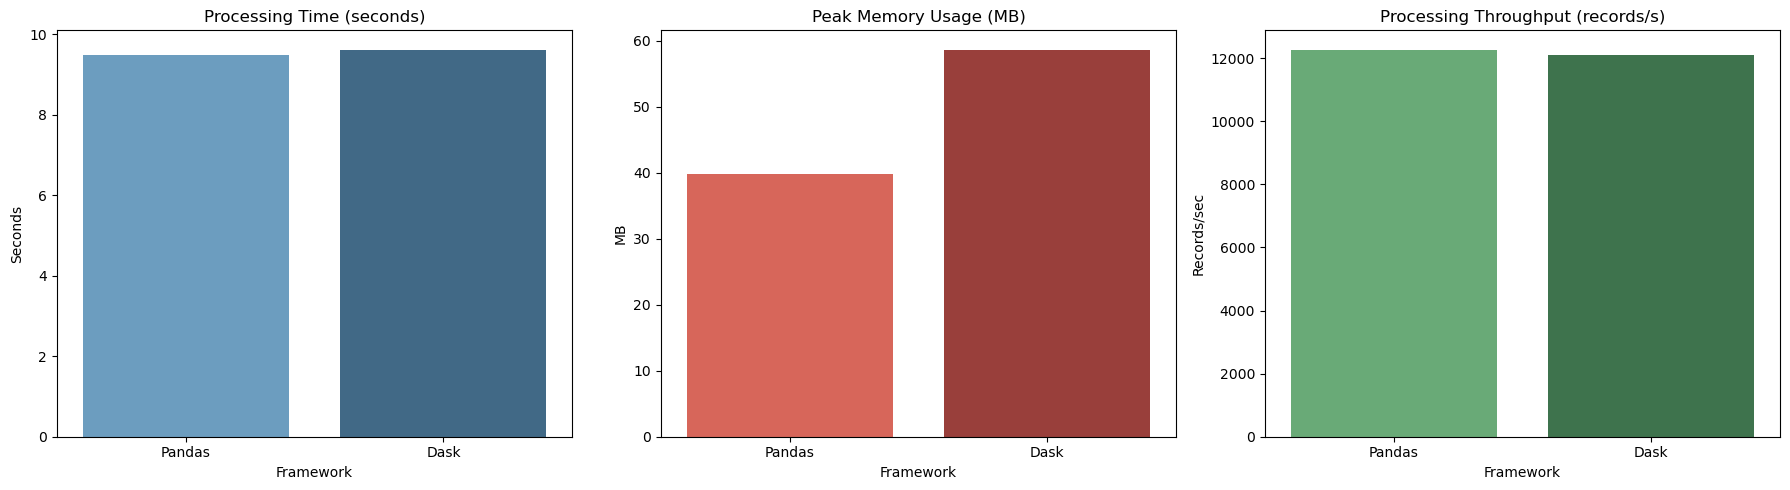

In [9]:
# Build DataFrame for visualization
perf_df = pd.DataFrame({
    "Framework": ["Pandas", "Dask"],
    "Elapsed Time (s)": [elapsed_pandas, elapsed_dask],
    "Peak Memory (MB)": [peak_mem_pandas, peak_mem_dask],
    "Records Processed": [df_copy.shape[0], df_clean_dask.shape[0]]
})

# Calculate throughput (records per second)
perf_df["Throughput (records/s)"] = perf_df["Records Processed"] / perf_df["Elapsed Time (s)"]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot: Processing Time
sns.barplot(data=perf_df, x="Framework", y="Elapsed Time (s)", ax=axes[0], palette="Blues_d")
axes[0].set_title("Processing Time (seconds)")
axes[0].set_ylabel("Seconds")

# Plot: Peak Memory Usage
sns.barplot(data=perf_df, x="Framework", y="Peak Memory (MB)", ax=axes[1], palette="Reds_d")
axes[1].set_title("Peak Memory Usage (MB)")
axes[1].set_ylabel("MB")

# Plot: Processing Throughput
sns.barplot(data=perf_df, x="Framework", y="Throughput (records/s)", ax=axes[2], palette="Greens_d")
axes[2].set_title("Processing Throughput (records/s)")
axes[2].set_ylabel("Records/sec")

# Tight layout for better formatting
plt.tight_layout()
plt.show()


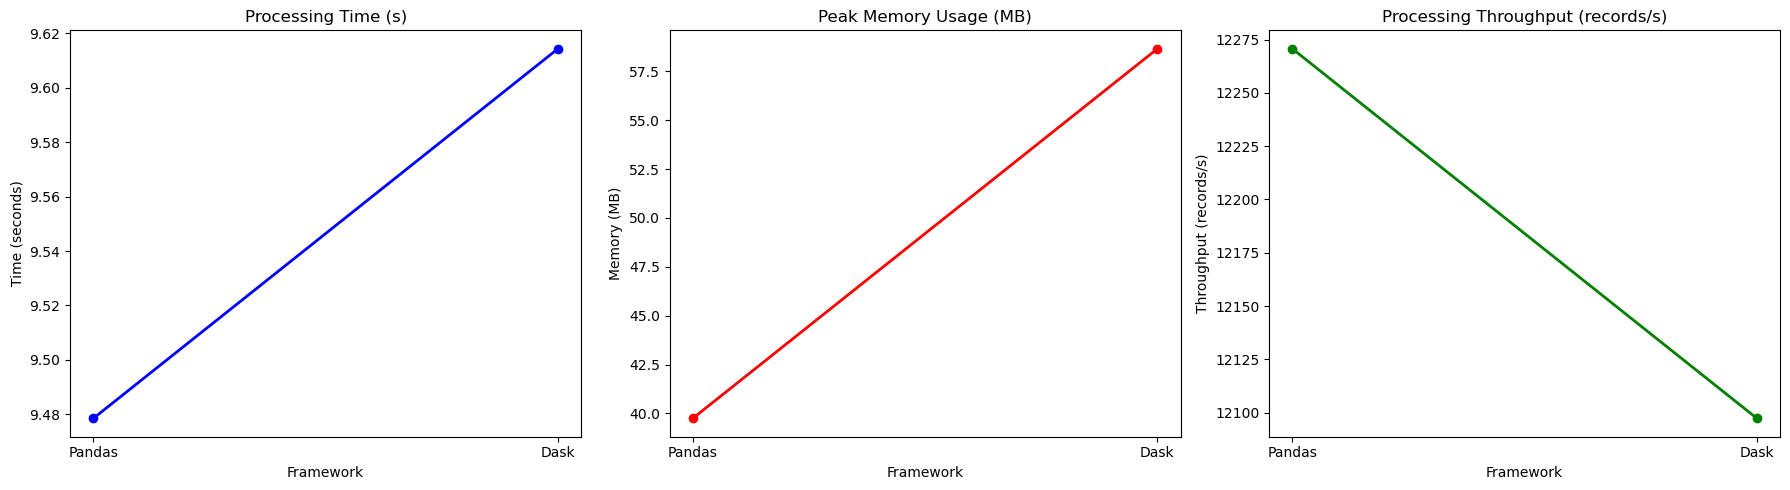

In [10]:
# Prepare the data for plotting the line graph
frameworks = ["Pandas", "Dask"]
elapsed_time = [elapsed_pandas, elapsed_dask]
peak_memory = [peak_mem_pandas, peak_mem_dask]
records_dask = df_clean_dask.shape[0]
throughput = [df_copy.shape[0] / elapsed_pandas, records_dask / elapsed_dask]

# Create the figure and axis objects for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot: Processing Time (Line Graph)
axes[0].plot(frameworks, elapsed_time, marker='o', color='b', linestyle='-', linewidth=2)
axes[0].set_title("Processing Time (s)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Time (seconds)")

# Plot: Peak Memory Usage (Line Graph)
axes[1].plot(frameworks, peak_memory, marker='o', color='r', linestyle='-', linewidth=2)
axes[1].set_title("Peak Memory Usage (MB)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Memory (MB)")

# Plot: Processing Throughput (Line Graph)
axes[2].plot(frameworks, throughput, marker='o', color='g', linestyle='-', linewidth=2)
axes[2].set_title("Processing Throughput (records/s)")
axes[2].set_xlabel("Framework")
axes[2].set_ylabel("Throughput (records/s)")

# Add tight layout for better formatting
plt.tight_layout()
plt.show()